# What makes a LinkedIn post good ?

## Context
Nowadays, a lot of businesses are based on the relationship with their prospects and clients. Therefore LinkedIn is the perfect online platform to create trust, by sharing stories, advices, or anything else ia posts.

Also a lot of "Linkedin experts" propose their services for companies to increase their visibility on this social media.  

Understanding what makes a post good on LinkedIn is essential to develop the reach, create qualitative interactions with prospects, and therefore increase business revenus. 

In this notebook, we will study a dataset provided on Kaggle to understand which criteria make a post "good" on this social media. 

## Dataset provided on Kaggle

You will find the link to this dataset on Kaggle website : https://www.kaggle.com/shreyasajal/linkedin-influencers-data

I would like to thank Shreya Sajal for providing it.

Here what she wrote about this dataset, on Kaggle :

""

This dataset contains LinkedIn Influencers' post details and other details(post dependent as well as independent) per post. This dataset can be used to analyze LinkedIn reach based on post content and related account details.

This dataset is great for Exploratory Data Analysis and NLP tasks.

The data was scraped using BeautifulSoup and Selenium.Last updated on 15th Feb,2021

""

*In this repository, the dataset is stored as a pickle file : "influencers_data.pkl"*

## What will you find in this notebook ?

In this project, we will :

* Explore it and understand how it is organized
* Do basic cleaning, like removing Nan and useless data
* Draw insights with EDA :
    * Authors overview
    * Influence of adding a medium in the post with hypothesis tests
* Set up posts topic modeling by :
    * Cleaning written posts 
    * Grouping words together (phrases/sentences)
    * Defining topics with Latent Dirichlet Allocation (LDA)
    * And finally exposing which topics lead to the most reactions

I hope you will enjoy this work. Have a good reading !

## Contents

* [Libraries](#1)
* [First exploratory](#2)
* [First cleaning](#3)
* [Exploratory Data analysis](#4)
* [Influence of topics](#5)
* [General conclusions](#6)
* [Personnal note](#7)
* [Aknowledgment](#8)

## Libraries <a class="anchor" id="1"></a>

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy # NLP
import itertools as it # Transform an object into an iterator. This is especially useful for generator objects
import re # Used with re.sub method, allowing us to remove patterns from a string
from gensim.models import Phrases # Trained model returning Sentences/Phrases, which are group of words generally associated together, like "ice_cream"
from gensim.corpora import Dictionary # Create a Dictionnary for LDA
from gensim.models.ldamulticore import LdaModel #Latent Dirichlet Allocation
from gensim.models import CoherenceModel # Calculate the coherence of our LDA model, which will tells us if the model is good or not

## First exploratory

Before anything going deep into the dataset, let's just check what is inside.  
If you want directly my first analysis of columns, go [there](#fastAnalysis)

In [3]:
# Download the dataset
df = pd.read_pickle("influencers_data.pkl")

In [4]:
# First look
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34012 entries, 0 to 34011
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         34012 non-null  int64  
 1   name               34012 non-null  object 
 2   headline           34012 non-null  object 
 3   location           31740 non-null  object 
 4   followers          33970 non-null  float64
 5   connections        25713 non-null  object 
 6   about              34012 non-null  object 
 7   time_spent         34011 non-null  object 
 8   content            31996 non-null  object 
 9   content_links      34012 non-null  object 
 10  media_type         26779 non-null  object 
 11  media_url          34012 non-null  object 
 12  num_hashtags       34012 non-null  int64  
 13  hashtag_followers  34012 non-null  int64  
 14  hashtags           34012 non-null  object 
 15  reactions          34012 non-null  int64  
 16  comments           340

We spot some columns without values

In [5]:
# Number of Nan in %
df.isna().sum() / df.shape[0] * 100

Unnamed: 0             0.000000
name                   0.000000
headline               0.000000
location               6.679995
followers              0.123486
connections           24.400212
about                  0.000000
time_spent             0.002940
content                5.927320
content_links          0.000000
media_type            21.266024
media_url              0.000000
num_hashtags           0.000000
hashtag_followers      0.000000
hashtags               0.000000
reactions              0.000000
comments               0.000000
views                100.000000
votes                 99.747148
dtype: float64

What does the data look like ?

In [6]:
# Show the two first rows
df.head(2)

,Unnamed: 0,name,headline,location,followers,connections,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtag_followers,hashtags,reactions,comments,views,votes
0,0,Nicholas Wyman,CEO IWSI Group,NaN,6484.0,500+,Nicholas Wyman for the past 25 years has shone...,1 day ago,Robert Lerman writes that achieving a healthy...,[['https://www.linkedin.com/in/ACoAAACy1HkBviR...,article,['https://www.urban.org/urban-wire/its-time-mo...,4,0,"[['#workbasedlearning', 'https://www.linkedin....",12,1,NaN,NaN
1,1,Nicholas Wyman,CEO IWSI Group,NaN,6484.0,500+,Nicholas Wyman for the past 25 years has shone...,1 week ago,"National disability advocate Sara Hart Weir, ...",[['https://www.linkedin.com/in/ACoAAAHsfJgBb7_...,NaN,[],0,0,[],11,0,NaN,NaN


In [7]:
#Let's check Time_spent
df.time_spent.value_counts()

1 year ago       7753
2 years ago      5728
3 years ago      3759
4 years ago      2126
3 months ago     1456
2 months ago     1448
4 months ago     1279
10 months ago    1247
11 months ago    1133
8 months ago     1121
1 month ago      1120
9 months ago     1115
7 months ago      942
5 months ago      904
6 months ago      855
2 weeks ago       428
1 week ago        418
3 weeks ago       346
5 years ago       304
6 years ago        81
2 days ago         73
1 day ago          72
4 days ago         69
3 days ago         63
6 days ago         36
5 days ago         31
7 years ago        25
5 hours ago         8
4 hours ago         6
7 hours ago         6
1 hour ago          6
3 hours ago         6
20 hours ago        5
23 hours ago        5
6 hours ago         5
22 hours ago        5
14 hours ago        4
18 hours ago        4
2 hours ago         3
8 hours ago         3
9 hours ago         3
15 hours ago        2
19 hours ago        2
13 hours ago        2
10 hours ago        1
21 hours a

In [8]:
#Let's check Media_type
df.media_type.value_counts()

article       15144
image          8708
video          2690
document        113
poll             86
entity           32
newsletter        4
view              2
Name: media_type, dtype: int64

In [9]:
#Content_links
df.content_links[0]

"[['https://www.linkedin.com/in/ACoAAACy1HkBviRGLfLG__Jk8FRH2JY2rGg3nTU', 'Robert Lerman'], ['https://www.linkedin.com/feed/hashtag/?keywords=workbasedlearning&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360', '#workbasedlearning'], ['https://www.linkedin.com/feed/hashtag/?keywords=usa&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360', '#USA'], ['https://www.linkedin.com/feed/hashtag/?keywords=apprenticeship&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360', '#apprenticeship'], ['https://www.linkedin.com/feed/hashtag/?keywords=urbanwire&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360', '#UrbanWire'], ['https://www.linkedin.com/company/urban-institute/', 'Urban Institute']]"

In [10]:
#Media_url
df.media_url.head()[0]

"['https://www.urban.org/urban-wire/its-time-modernize-american-apprenticeship-system']"

In [11]:
#Hashtags_followers
df.hashtag_followers.value_counts()

0    34012
Name: hashtag_followers, dtype: int64

In [12]:
#hashtags
df.hashtags[0]

"[['#workbasedlearning', 'https://www.linkedin.com/feed/hashtag/?keywords=workbasedlearning&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360'], ['#USA', 'https://www.linkedin.com/feed/hashtag/?keywords=usa&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360'], ['#apprenticeship', 'https://www.linkedin.com/feed/hashtag/?keywords=apprenticeship&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360'], ['#UrbanWire', 'https://www.linkedin.com/feed/hashtag/?keywords=urbanwire&highlightedUpdateUrns=urn%3Ali%3Aactivity%3A6765387069389967360']]"

In [13]:
# Votes
df.votes.value_counts()

265.0    3
240.0    2
141.0    2
256.0    1
305.0    1
        ..
195      1
881.0    1
59       1
2,131    1
387.0    1
Name: votes, Length: 82, dtype: int64

In [14]:
#Connections
df.connections.value_counts()

500+    25633
171        80
Name: connections, dtype: int64

In [15]:
#Location
df.location.value_counts().head()

['New', 'York,', 'New', 'York,', 'United', 'States']    4234
['Miami,', 'Florida,', 'United', 'States']              1959
['Hungary']                                             1846
['Cambridge,', 'England,', 'United', 'Kingdom']         1784
['New', 'York', 'City', 'Metropolitan', 'Area']         1738
Name: location, dtype: int64

In [16]:
#Location nan
df.location.isna().sum()

2272

In [17]:
#Media types
df.media_type.value_counts()

article       15144
image          8708
video          2690
document        113
poll             86
entity           32
newsletter        4
view              2
Name: media_type, dtype: int64

In [18]:
#Media types Nan
df.media_type.isna().sum()

7233

### Data check <a class="anchor" id="fastAnalysis"></a>

We have different columns in this dataset :

* **Unnamed** : to delete
* **Name** : Linkedin profile
* **Headline** : below the name in Linkedin
* **Location** : some Nan ; List : example ['Gloucester,', 'Massachusetts,', 'United', 'States']
* **Followers** : number of followers (connections + followers in Linkedin) ; This dataset is composed of **influencers** with a lot of followers
* **Connections** : careful of 500+ (is it useful ?) => only 2 differents values => delete it !
* **About** : about section in the profile
* **time_spent** : time between the post date & when this dataset was created (categorical values : 1 month ago, 5 years ago, ...)
* **Content** : core of the content
* **Content_links** : every links contained in the post : profile, #, media (artice, website, picture,...)
* **Media_type** : media added to the post : article, image, photo,... ; Some nan
* **Media_url** : link of the media
* **Num_hashtags** : number
* **Hashtag_followers** : nulls
* **Hashtags** : [['#',"link"]]
* **Reactions** : number of likes, supports, loves,... counted as identical
* **Comments** : number of comments
* **Views** : Nan
* **Votes** : 82 non-null, composed of decimal numbers too. Weird. Because it is unsignificant, we could delete it

## First cleaning <a class="anchor" id="3"></a>

Based on the previous analysis, we will clean the dataset

### Drop columns

In [19]:
# We drop useless columns
df_cleaned = df.drop(['Unnamed: 0','connections','hashtag_followers','views','votes'],axis=1)

### Replace values

In [20]:
# Replace Nan
df_cleaned.isna().sum()

name                0
headline            0
location         2272
followers          42
about               0
time_spent          1
content          2016
content_links       0
media_type       7233
media_url           0
num_hashtags        0
hashtags            0
reactions           0
comments            0
dtype: int64

#### Location


In [21]:
# Replace Nan by "Unknown"
df_cleaned['Location'] = df_cleaned['location'].fillna('Unknown')
df_cleaned.drop(['location'],axis=1,inplace=True)

#### Followers

To avoid any bias, let's take the mean to replace Nan.  
There are only 42 missing values.

In [22]:
# Followers mean
Followers_mean = df_cleaned.followers.mean()
Followers_mean

1125922.2806005299

In [23]:
# Replace Nan by the mean
df_cleaned["Followers"] = df_cleaned['followers'].fillna(Followers_mean)
df_cleaned.drop(['followers'],axis=1,inplace=True)

#### Time spent

There is only one missing value. 

In [24]:
df_cleaned.loc[df_cleaned['time_spent'].isna()]

,name,headline,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtags,reactions,comments,Location,Followers
14049,Gary Frisch,30-Year Public Relations Pro and Skilled Writer,I began my public relations careers when the S...,NaN,"Amid Coronavirus, PR pros should tread careful...",[],article,['https://www.linkedin.com/pulse/public-relati...,0,[],8,2,"['Greater', 'Philadelphia']",30971.0


We see it's about coronavirus.    
We can think the post was published the day the extraction was done.  
For this reason, let's replace Nan by "Current date"

In [25]:
df_cleaned['Time_spent'] = df_cleaned['time_spent'].fillna('Current date')
#Drop the previous column
df_cleaned.drop(['time_spent'],axis=1,inplace=True)

#### Content

The question we decided to treat is about post contents.  
Therefore we have no reason to keep rows without content.  
Let's drop them

In [26]:
df_cleaned = df_cleaned.loc[df_cleaned['content'].notnull()]

#### Media

We suppose that Nan means there is no media in the post.
Let's replace it by "None"

In [27]:
df_cleaned['Media_type'] = df_cleaned["media_type"].fillna("None")
df_cleaned.drop(['media_type'],axis=1,inplace=True)

#### Is everything ok ?

In [28]:
df_cleaned.isna().sum()

name             0
headline         0
about            0
content          0
content_links    0
media_url        0
num_hashtags     0
hashtags         0
reactions        0
comments         0
Location         0
Followers        0
Time_spent       0
Media_type       0
dtype: int64

YES !

In [29]:
# How many rows did we drop ?
print('We dropped {} rows from the original dataset'.format(df.shape[0]-df_cleaned.shape[0]))

We dropped 2016 rows from the original dataset


The data is now ready to be explored.

### Export the dataset

In [30]:
# Because we have removed rows, we have to reset_index
df_cleaned.reset_index(inplace=True,drop=True)

# We export it as a pkl
df_cleaned.to_pickle("cleaned_data.pkl")

## Exploratory Data Analysis <a class="anchor" id="4"></a>

Now we have cleaned the dataset, we can now highlight some intersting insights.

In [31]:
data = pd.read_pickle('cleaned_data.pkl')

### Overview of the authors

In [32]:
#Let's draw the authors relatively to their number of followers and reaction means

#Reactions and followers means for each authors
authors_df = pd.pivot_table(data,index="name",values=["reactions","Followers"],aggfunc='mean')

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_11552/4256639052.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(k) for k in current_values])
C:\Users\Jeremy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127945 (\N{RUGBY FOOTBALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


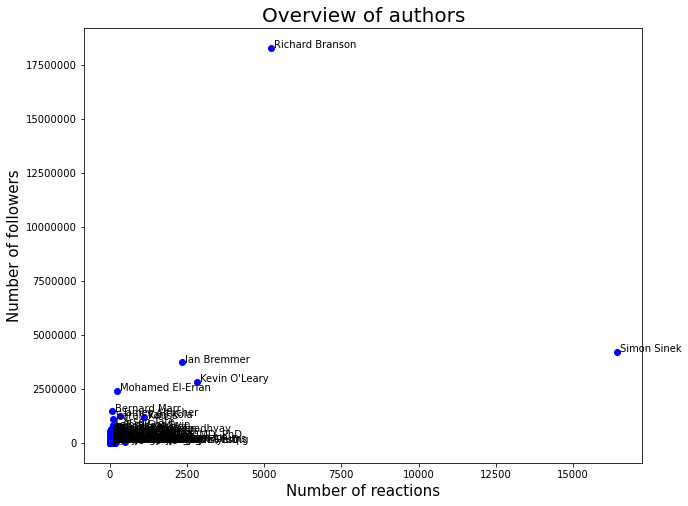

In [33]:
#Plot
plt.rcParams['figure.figsize'] = [10, 8]

for author in authors_df.index:
    x = authors_df.reactions.loc[author]
    y = authors_df.Followers.loc[author]
    plt.scatter(x, y, color='blue')
    plt.text(x+100, y+100, author, fontsize=10)

plt.title('Overview of authors', fontsize=20)
plt.xlabel('Number of reactions', fontsize=15)
plt.ylabel('Number of followers', fontsize=15)

#Format yaxis to avoid scientific notation
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(k) for k in current_values])

plt.show()

**Observation**  

As we can see, Simon Sinek & Richard Branson are outliers.  
Simon Sinek has a lot of reactions whereas Richard Branson has a lot of followers.  
But both have more than other authors.  

To visualize the entire dataset, let's plot in log scale

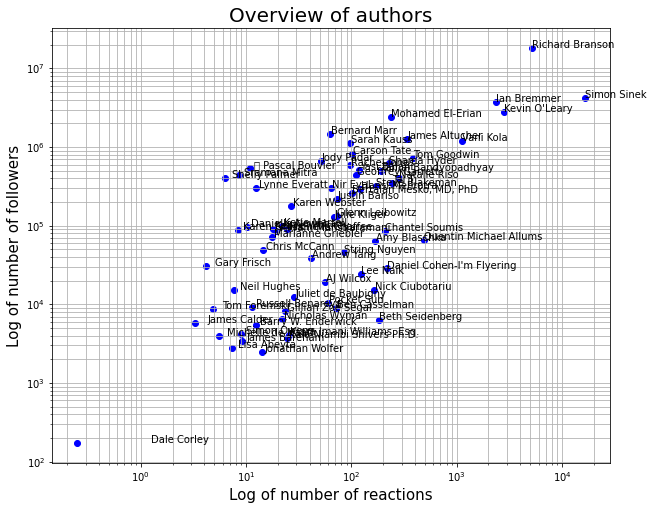

In [34]:
#Plot
plt.rcParams['figure.figsize'] = [10, 8]

for author in authors_df.index:
    x = authors_df.reactions.loc[author]
    y = authors_df.Followers.loc[author]
    plt.scatter(x, y,color='Blue')
    plt.text(x+1, y+1, author, fontsize=10)

plt.title('Overview of authors', fontsize=20)
plt.xlabel('Log of number of reactions', fontsize=15)
plt.ylabel('Log of number of followers', fontsize=15)

# Set logarithmic scale on the both variables
ax=plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

#Grid
plt.grid(visible=True,which='both')

#Format yaxis to avoid scientific notation
# plt.gca().set_yticklabels('{:.0f}'.format())

plt.show()

**Observation**  

**1.**  
We observe a  relation between the number of followers & reactions.   
The higher the number of followers, the higher the number of reactions, following a power law :

$$ n_{followers} = k n_{react} ^ \mu $$ 
with $(k,\mu)$ constants.

To keep it simple, it is needed a lot of followers to have a good quantity of reactions.  

This is pretty logical because people just watch content of influencers they follow but don't react to their posts everytime. 

**2.**  
Therefore, in our analysis, which is understanding what makes a Linkedin post good, we should study one author's posts at a time.  

Also we could express if a post is good or not with the following relationship, in order to normalize observations when we will compare authors each others :

$$ attractivity = \frac{\#reactions + \#comments}{\#followers} $$

In [35]:
# We define attractivity factor
#Let's use the formula above, in %
data['Attractivity'] = 100*(data.reactions + data.comments) / data.Followers

Let's check the outliers in term of atttractivity.  
We remove Sinek & Branson from our data to see if they are guilty.

In [36]:
data_no_sinek_branson = data.loc[(data.name != "Simon Sinek") & (data.name != 'Richard Branson')]

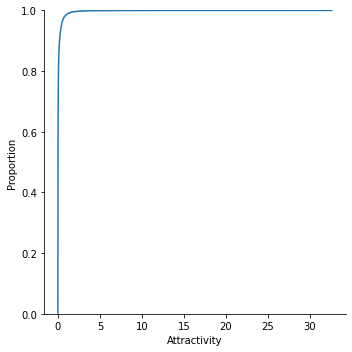

In [37]:
#With outliers
sns.displot(data=data,x='Attractivity',kind='ecdf')

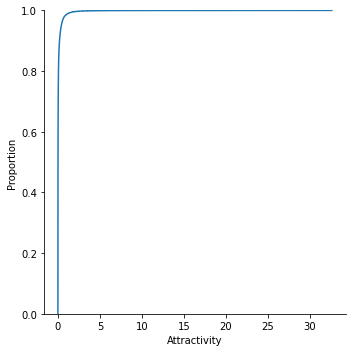

In [38]:
# And without them
sns.displot(data=data_no_sinek_branson,x='Attractivity',kind='ecdf')

**Observations**  

Even after removing Sinek & Branson, we still have outliers.  
Let's check that

In [39]:
PivotTable = pd.pivot_table(data=data, index='name', values=['reactions',"Followers","Attractivity",'comments'],aggfunc='max')
PivotTable.sort_values(by="Attractivity",ascending=False)

,Attractivity,Followers,comments,reactions
name,,,,
Kaia Niambi Shivers Ph.D.,32.590604,3.725000e+03,71,1143
Nick Ciubotariu,22.579373,1.521300e+04,284,3151
Lee Naik,20.094031,2.446000e+04,481,4434
Quentin Michael Allums,19.799057,6.638700e+04,2544,10600
Ben Casselman,15.165512,9.093000e+03,356,1023
...,...,...,...,...
Karen Webster,0.102043,1.783560e+05,34,175
🏉 Pascal Bouvier,0.087999,5.465970e+05,73,410
Bernard Marr,0.040284,1.462121e+06,322,565


**Observations**  

As we can see, there are some outliers in term of attractivity even if it is not Sinek or Branson.  
Attractivity is maybe not a good feature to analyse our data.  

Therefore, for the sake of our study, it would be better to not compare authors, but to take them individually, and see if we can highlight some patterns across these authors.

### Influence of media presence in a post

Here, we are going to check if adding a medium in the post has an influence on the attractivity.

In [40]:
#First of all, let's count how many times are used each media in this dataset
data.Media_type.value_counts()

article       14590
image          8614
None           5889
video          2674
document        110
poll             82
entity           31
newsletter        4
view              2
Name: Media_type, dtype: int64

Articles, images and videos are majoritarly used in posts.  
We note also a lot of posts without a medium.

Let's see what the influence of a media on the attractivity. 


In [41]:
# Let's create a copy of the dataset
media_df = data.copy()

In [42]:
#Let's create a new column 0 for no media, 1 if a media
media_df['Media_in_post'] = media_df.Media_type.apply(lambda x: 0 if x=="None" else 1)

Let's check for one author

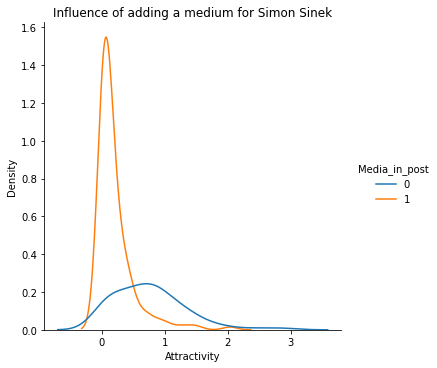

In [43]:
#Distribution for one author : Simon Sinek
ax = sns.displot(data=media_df.loc[media_df.name == "Simon Sinek"],x='Attractivity',hue='Media_in_post',kind='kde')
ax.set(title ='Influence of adding a medium for Simon Sinek')

**Observations** 

For one author, we note that using a medium in the post increases the attractivity.  
We note also that it increases the variance too.  
So we can considere that using a medium doesn't ensure that the post will have more reactions, but tends to.

An hypothesis test have to be done !

Let's apply this test to all authors at the same time.

In [44]:
#Create the dataframe
MediaAttractivity = pd.DataFrame()
MediaAttractivity["Author"] = media_df.name.unique()

#Use pivot table to obtain average attractivity
PivotTableAttractivityMean = pd.pivot_table(data=media_df,index='name',columns='Media_in_post',values='Attractivity',aggfunc='mean')
#Add attractivity means to the dataframe
MediaAttractivity['Avg_Attract_NoMedia'] = np.array(PivotTableAttractivityMean[0])
MediaAttractivity['Avg_Attract_Media'] = np.array(PivotTableAttractivityMean[1])

#Add the difference between Media & NoMedia in %
MediaAttractivity['Diff_Media_Avg%'] = 100 * (MediaAttractivity['Avg_Attract_Media'] - MediaAttractivity['Avg_Attract_NoMedia'])/MediaAttractivity['Avg_Attract_NoMedia']

#Calculate also the variance
PivotTableAttractivityVariance = pd.pivot_table(data=media_df,index='name',columns='Media_in_post',values='Attractivity',aggfunc='var')
MediaAttractivity['Var_Attract_NoMedia'] = np.array(PivotTableAttractivityVariance[0])
MediaAttractivity['Var_Attract_Media'] = np.array(PivotTableAttractivityVariance[1])

#Difference of variances
MediaAttractivity['Diff_Media_Var%'] = 100 * (MediaAttractivity['Var_Attract_Media'] - MediaAttractivity['Var_Attract_NoMedia'])/MediaAttractivity['Var_Attract_NoMedia']

In [45]:
MediaAttractivity

,Author,Avg_Attract_NoMedia,Avg_Attract_Media,Diff_Media_Avg%,Var_Attract_NoMedia,Var_Attract_Media,Diff_Media_Var%
0,Nicholas Wyman,0.338293,0.416448,23.102937,0.374618,0.191829,-48.793396
1,Jonathan Wolfer,0.052674,0.378409,618.397997,0.002443,0.044621,1726.405676
2,Karen Gross,0.090432,0.115388,27.595532,0.006671,0.017940,168.908467
3,Kaia Niambi Shivers Ph.D.,0.297353,0.269192,-9.470455,0.158750,0.247783,56.083278
4,Daniel Cohen-I'm Flyering,1.126141,1.081418,-3.971354,2.891937,5.597374,93.551037
...,...,...,...,...,...,...,...
63,Quentin Michael Allums,0.072650,0.034469,-52.554341,0.012890,0.001587,-87.690157
64,AJ Wilcox,0.080693,0.102754,27.340108,0.006586,0.088367,1241.699171
65,Kevin O'Leary,0.018051,0.027062,49.918334,0.001982,0.002328,17.454367
66,Amy Blaschka,0.036735,0.021744,-40.810306,0.001333,0.000425,-68.134394


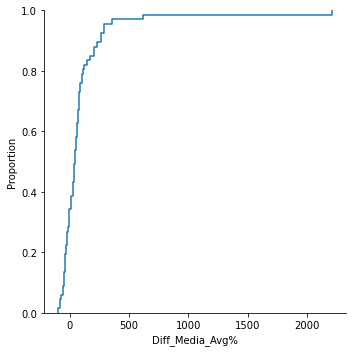

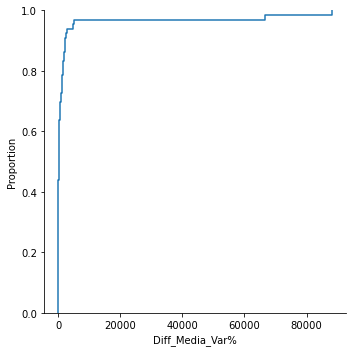

In [46]:
#Let's plot distributions
sns.displot(data=MediaAttractivity,x="Diff_Media_Avg%",kind='ecdf')
sns.displot(data=MediaAttractivity,x="Diff_Media_Var%",kind='ecdf')

**Observations**  

As we can see, some authors are outliers considering the difference between a post with or without a medium.  
Let's check these authors !

In [47]:
# Check this outliers : Avg
# We will keep 95% of the distribution
quantileAvg = MediaAttractivity['Diff_Media_Avg%'].quantile(q=0.95)
MediaAttractivity.loc[MediaAttractivity['Diff_Media_Avg%'] >= quantileAvg]

,Author,Avg_Attract_NoMedia,Avg_Attract_Media,Diff_Media_Avg%,Var_Attract_NoMedia,Var_Attract_Media,Diff_Media_Var%
1,Jonathan Wolfer,0.052674,0.378409,618.397997,0.002443,0.044621,1726.405676
12,Michelle Chaffee,0.204970,0.939667,358.441801,0.079282,1.162754,1366.598893
19,Ian Bremmer,0.019128,0.074649,290.263030,0.000319,0.213016,66700.389428
58,Juliet de Baubigny,0.002703,0.062395,2208.371041,0.000008,0.006896,88151.674174


In [48]:
#Check this outliers : Var
quantileVar = MediaAttractivity['Diff_Media_Var%'].quantile(q=0.95)
MediaAttractivity.loc[MediaAttractivity['Diff_Media_Var%'] >= quantileVar]

,Author,Avg_Attract_NoMedia,Avg_Attract_Media,Diff_Media_Avg%,Var_Attract_NoMedia,Var_Attract_Media,Diff_Media_Var%
19,Ian Bremmer,0.019128,0.074649,290.263030,0.000319,0.213016,66700.389428
28,Marianne Griebler,0.351976,0.774049,119.915254,0.269617,13.380212,4862.664941
34,Gillian Zoe Segal,0.260805,0.802110,207.551708,0.041255,2.137030,5079.997622
58,Juliet de Baubigny,0.002703,0.062395,2208.371041,0.000008,0.006896,88151.674174


**Observations**

It seems there are some outliers, above a quantile of 95% (especially Juliette de Baubigny)  
Let's remove these authors for this analysis.

In [49]:
#Take these names into a list
OutlierAuthors = ['Jonathan Wolfer','Michelle Chaffee','Ian Bremmer','Juliet de Baubigny','Marianne Griebler','Gillian Zoe Segal']

In [50]:
#Change index into authors'name
MediaAttractivity = MediaAttractivity.set_index('Author')

In [51]:
#Drop the outlier
MediaAttractivity.drop(index=OutlierAuthors,inplace=True) #Inplace means no copy created

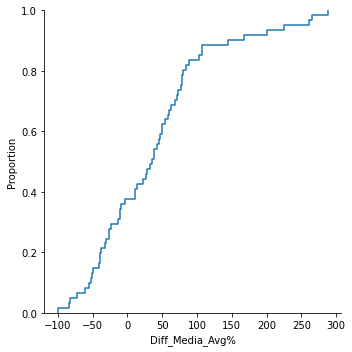

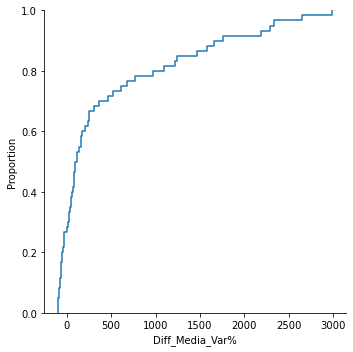

In [52]:
#Check distribution again
sns.displot(data=MediaAttractivity,x="Diff_Media_Avg%",kind='ecdf')
sns.displot(data=MediaAttractivity,x="Diff_Media_Var%",kind='ecdf')

In [53]:
#Now let's calculate the mean of differences across authors, in % compared to NoMedia
MediaAttractivityDiffAvg = MediaAttractivity['Diff_Media_Avg%'].mean()
MediaAttractivityDiffVar = MediaAttractivity['Diff_Media_Var%'].mean()
print('In average, adding a media increases the attractivity of a post by {:.2f} %'.format(MediaAttractivityDiffAvg))
print('And the variance by {:.2f} %'.format(MediaAttractivityDiffVar))

In average, adding a media increases the attractivity of a post by 38.55 %
And the variance by 476.62 %


**Observations**

So, for 95% of authors, we observe a significant increase in attractivity, about 39%, by adding a medium in the post. 

**However**, this result has to be taken with precautions, because the variance increases a lot too, meaning that adding a medium doesn't ensure to have a better attractivity. 

*Therefore, let's test this hypothesis.*

**Hypothesis test**

First of all, let's formulate our hypothesis, with $\mu$ the hypothesis mean

$ H_0 $ : Media doesn't improve attractivity => $\mu \le 0\%$  
$ H_1 $ : Media improves attractivity => $\mu > 0\%$

We take a significance level $\alpha = 0.05$.  
This value defines the degree of confidence we have in our hypothesis test.  
For instance, we will be sure at 95% that our decision will be correct (True positive). 

The test is one-sided.

The distribution follows a Normal Distribution, and we consider that the variance of this sample is the same as the population.
We can therefore use a Z-test. 

$$ Z= \frac{\bar{x} - \mu}{s / \sqrt n} $$

with :
* $\bar{x}$ the sample mean
* $s$ the sample standard type
* $n$ the sample size

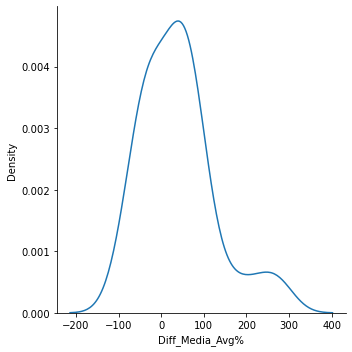

In [54]:
#% increase distribution
sns.displot(data=MediaAttractivity,x="Diff_Media_Avg%",kind='kde')

In [55]:
mu = 0 #Hypothesis mean
s = MediaAttractivity['Diff_Media_Avg%'].std() #Standard type
n = MediaAttractivity.shape[0] #Sample size

#Z-score
Z = (MediaAttractivityDiffAvg - mu) / (s / np.sqrt(n))

print('Z-score =',Z)

Z-score = 3.5188783229488854


The Z-table

<img src="https://www.ztable.net/wp-content/uploads/2018/11/negativeztable.png">

After checking the Z-table, we got a value of 0.99978 > 0.95.  
Which means $H_0$ is rejected :

**Adding a media in the post tends to increase the attractivity of the post.**


*Is this still true if we consider an increase of 30%*

To verify that, let's do another hypothesis test :

$H_0$ : $<30\%$  
$H_1$ : $>=30\%$

We keep a significance level $\alpha = 0.05$

In [56]:
mu = 30 #Hypothesis mean
s = MediaAttractivity['Diff_Media_Avg%'].std() #Standard type
n = MediaAttractivity.shape[0] #Sample size

#Z-score
Z = (MediaAttractivityDiffAvg - mu) / (s / np.sqrt(n))

print('Z-score =',Z)

Z-score = 0.7806992681896487


**However**, we can't say that posting a media increases more than 30% the post attractivity.  


A Z-score > 2 is a good value to consider $H_0$ as rejected.  
In our case, it would be an increase of around **16%**

In [57]:
mu = 16 #Hypothesis mean
s = MediaAttractivity['Diff_Media_Avg%'].std() #Standard type
n = MediaAttractivity.shape[0] #Sample size

#Z-score
Z = (MediaAttractivityDiffAvg - mu) / (s / np.sqrt(n))

print('Z-score =',Z)

Z-score = 2.0585161604106257


**Conclusions**

Adding a media in the post increases by around **16%** the attractivity, with a 95% confidence. 

*Note*  
This confidence means : if we take 100 samples, 95 of the time we will find that adding a medium increases by at least 16% the attractivity.

## Influence of topics <a class="anchor" id="5"></a>

We will now dig deeper in our analysis. Because posts are written, we can therefore use Natural Language Processing to try to define which topics are the most attractive !

But before using Unsupervized machine learning algorithm on these posts, we have to clean them first to be easily understandable by the machine.


**Cleaning The Data**    

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**

* Make text all lower case  
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**

* Stemming / lemmatization
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

In [58]:
# Let's download the cleaned dataset
df_cleaned = pd.read_pickle('cleaned_data.pkl')
df_cleaned.head()

,name,headline,about,content,content_links,media_url,num_hashtags,hashtags,reactions,comments,Location,Followers,Time_spent,Media_type
0,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Robert Lerman writes that achieving a healthy...,[['https://www.linkedin.com/in/ACoAAACy1HkBviR...,['https://www.urban.org/urban-wire/its-time-mo...,4,"[['#workbasedlearning', 'https://www.linkedin....",12,1,Unknown,6484.0,1 day ago,article
1,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,"National disability advocate Sara Hart Weir, ...",[['https://www.linkedin.com/in/ACoAAAHsfJgBb7_...,[],0,[],11,0,Unknown,6484.0,1 week ago,None
2,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Exploring in this months Talent Management & H...,[['https://www.linkedin.com/in/ACoAAAADlGIBLfn...,['https://www.tlnt.com/apprenticeships-that-br...,4,"[['#careerplanning', 'https://www.linkedin.com...",44,0,Unknown,6484.0,2 months ago,article
3,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,I count myself fortunate to have spent time wi...,[['https://www.linkedin.com/in/ACoAABhNxDUB9IX...,['https://gritdaily.com/the-legacy-of-verified...,3,"[['#verifiedresumes', 'https://www.linkedin.co...",22,2,Unknown,6484.0,2 months ago,article
4,Nicholas Wyman,CEO IWSI Group,Nicholas Wyman for the past 25 years has shone...,Online job platforms are a different way of wo...,[['https://www.linkedin.com/feed/hashtag/?keyw...,['https://www.forbes.com/sites/nicholaswyman/2...,5,"[['#careers', 'https://www.linkedin.com/feed/h...",21,1,Unknown,6484.0,2 months ago,article


In [59]:
# Let's check some posts to see what we have to do
print(df_cleaned['content'][100])
print('---------')
print(df_cleaned['content'][1000])
print('---------')
print(df_cleaned['content'][10000])

After decades of corporate reform in our public schools, the results are in. And it's not good news for the reformers.  On the National Assessment of Educational Progress (NAEP), which is the only assessment nationally normed and administered, this year' results showed stagnation over prior years tests, and increases in gaps between the highest-performing students and the lowest. The evidence rolls in persuasively that administering more and more assessments - diagnostic, district, state, and now nationally - in an effort to increase test scores - with the added costs and consequences of higher class sizes and fewer classes in #education #reform #gap the arts and humanities - have resulted in no improvement in reading or math scores.  It's time to stop the testing madness, and time to return to what engages our learners in our schools...it sure isn't more testing and more test preparation. 
 
 
 …see more
---------
✨ Today marks my last day at Studio71! ✨ I am so grateful for my time h

**Observations**

As we can see with these examples, we can remove from these posts :

* Uppercases
* "...see more" at the end of each post. 
    * If we check the raw version of posts (see the following cell), it appears that it is written as "\n \n \n …see more"
    * It means also that we don't have complete posts in this dataset !
* Punctuations
* Hashtags. Indeed, some hashtags have no sense, which is pretty difficult for topic modeling
* Whitespaces
* Emojis
* Names

We can also lemmatize the text.  
**Lemmatization** consists in transforming a word into its root. For instance, "is" becomes "be" ; "me" becomes "I" ...

**Stopwords** can also be removed. Stopwords are words which does not add much meaning to a sentence in the selected language. For instance, 'very', 'sometime', 'thereby are considered as stopwords in English

In [60]:
# Watch "\n \n \n …see more" at the end of the post
df_cleaned['content'][1000]

'✨ Today marks my last day at Studio71! ✨ I am so grateful for my time here and for having a position that allowed me to work across departments.  One of my favorite leaders at  Studio71, LP  is  Mike Fallon . He once told me:  “You should always make sure you listen as much as you talk. You don\'t have to agree, but you have to make sure they feel heard."  Thanks for always making me feel heard.  Thank you to the team  Garima Sharma ,  Emily Badgley ,  Tristan DiMaria ,  Alex Shannon , and so many more. I am going to miss y\'all a ton! I will be announcing my next opportunity in the upcoming weeks, so stay tuned! #lastday   #gratitude   #careertransition \n \n \n …see more'

Let's declare a specific Dataframe we will work with, containing posts and relevant informations to study the impact of topics

In [61]:
# Let's keep only columns we need for this topic modeling
# We rename columns to stay consistent (uppercase lowercase etc)
corpus = pd.DataFrame()
corpus[['Name', "#Reactions", "#Comments", "Followers", "Content"]] = df_cleaned[['name','reactions','comments','Followers','content']]
corpus

,Name,#Reactions,#Comments,Followers,Content
0,Nicholas Wyman,12,1,6484.0,Robert Lerman writes that achieving a healthy...
1,Nicholas Wyman,11,0,6484.0,"National disability advocate Sara Hart Weir, ..."
2,Nicholas Wyman,44,0,6484.0,Exploring in this months Talent Management & H...
3,Nicholas Wyman,22,2,6484.0,I count myself fortunate to have spent time wi...
4,Nicholas Wyman,21,1,6484.0,Online job platforms are a different way of wo...
...,...,...,...,...,...
31991,Simon Sinek,4005,93,4206024.0,Igniter of the Year 2016. Well I know that I'm...
31992,Simon Sinek,1698,74,4206024.0,Executives who prioritize the shareholder are ...
31993,Simon Sinek,661,59,4206024.0,"Like many, I too have been reflecting as we ne..."
31994,Simon Sinek,766,35,4206024.0,"If you say ""customer first"" that means your em..."


In [62]:
# Let's also create a serie representing the content only
# It will be very useful for the later use
posts = corpus['Content']

### Pre-processing

For this preprocessing, we will use Spacy, which is a fast industrial-strength natural language processing (NLP) library for Python.

spaCy handles many tasks commonly associated with building an end-to-end natural language processing pipeline:

* Tokenization
* Text normalization, such as lowercasing, stemming/lemmatization
* Part-of-speech tagging
* Syntactic dependency parsing
* Sentence boundary detection
* Named entity recognition and annotation

In the "batteries included" Python tradition, spaCy contains built-in data and models which you can use out-of-the-box for processing general-purpose English language text:

* Large English vocabulary, including stopword lists
* Token "probabilities"
* Word vectors

In [63]:
# We need to import spacy trained pipelines, which support many languages
# Let's use the English pipeline

# In CMD :
# $ python -m spacy download en_core_web_lg
# or
# In python :
# >>> import spacy
# >>> nlp = spacy.load("en_core_web_lg")

# We download the large version "lg" and not the small version "sm" here 
# This module is pretty large : ~631 MB
nlp = spacy.load("en_core_web_lg")

First we remove every hashtags from posts with the following function.  
The reason is that tokenizing posts with spaCy does consider "#" as a single token, so we have to remove hashtags upstream.

In [64]:
def first_clean(post):
    """
    remove all hastags and website links from a string
    """    

    return " ".join(word for word in post.split(' ') if ("#" not in word and "http" not in word))

Let's see if the function worked 

In [65]:
print("Original posts :")
print("")

for post in posts[:3]:
    print(post)
    print("")

Original posts :

Robert Lerman  writes that achieving a healthy future of work requires employees to build skills that help them attain productive and rewarding careers. He notes - "one of the most cost-effective ways to do this is through apprenticeship, which helps workers master occupations and gain professional identity and pride". Coudlnt agree more!  #workbasedlearning   #USA   #apprenticeship   Read the article on  #UrbanWire   Urban Institute 
 
 
 …see more

National disability advocate  Sara Hart Weir, MS   shares how Congress passed the ABLE act

Exploring in this months Talent Management & HR what a company should consider to get the most out of a modern apprenticeship program. Thanks to employer & entrepreneuer  Ankur Gopal  for sharing insights on your IT program.  Why not start a program in 2021.. Wishing you all a safe and happy festive season.  Nick  #careerplanning   #apprenticeships   #workbasedlearning   #careers   Urban Institute   Zach Boren   Robert Lerman   Lan

In [66]:
# Let's clean posts
posts = posts.apply(first_clean)

In [67]:
print("Cleaned posts :")
print("")

for post in posts[:3]:
    print(post)
    print("")

Cleaned posts :

Robert Lerman  writes that achieving a healthy future of work requires employees to build skills that help them attain productive and rewarding careers. He notes - "one of the most cost-effective ways to do this is through apprenticeship, which helps workers master occupations and gain professional identity and pride". Coudlnt agree more!        Read the article on    Urban Institute 
 
 
 …see more

National disability advocate  Sara Hart Weir, MS   shares how Congress passed the ABLE act

Exploring in this months Talent Management & HR what a company should consider to get the most out of a modern apprenticeship program. Thanks to employer & entrepreneuer  Ankur Gopal  for sharing insights on your IT program.  Why not start a program in 2021.. Wishing you all a safe and happy festive season.  Nick          Urban Institute   Zach Boren   Robert Lerman   Lana Gordon   Andrew Sezonov   Simon W.   Ervin Dimeny 
 
 
 …see more



**Hashtags were removed !**

Let's define some functions that will help us clean the texts, using spaCy !

nlp.pipe() allows use to apply the processing to a serie composed of texts. This is the main reason we have decided to work with a serie : 'posts'.

Each post, which is a string, is splitted into tokens recognized by the algorithm and pre-processed by the spaCy library. Each token can therefore be recognized as a type, like a noun, an adjective, a stopword, its lemmatized version, etc... This library is very powerful to treat natural language processing problems !

In [68]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space


def rm_pattern(post):
    """
    function returning a string without "...see more" and website links from the post. 
    This function uses "re.sub" to remove a specific pattern"""

    post = re.sub("…see more",'', post) # replace pattern by an empty string
    post = re.sub('http','',post)
    return post



def rules(token):
    """
    conditions to select a specific token for the corpus cleaning
    used with all() function : return True if all True.
    Conditions are : no pure puncuation - no pure whitespace - nouns & adjectives only - not a stopword 
    - not a #word
    """

    return [not punct_space(token),
            token not in nlp.Defaults.stop_words,
            token.pos_ == 'NOUN' or token.pos_ =="ADJ"] 

In [69]:
def corpus_cleaning(posts):
    """
    generator function using spaCy to parse posts,
    remove "...see more" pattern, website links, lemmatize the text, lowercase words, and apply all the conditions we have set in rules.
    What this function returns is a generator (a "list") of individual tokens contained in lists. 
    """
    
    for post in nlp.pipe(posts.apply(rm_pattern)):
        yield ' '.join([token.lemma_ for token in post if all(rules(token))])

*yield*, at the opposite of *return*, returns a generator, which is a lighter version of a list. It is very useful when the object is large, like our list of posts. However, generators can be iterated over only once ! The reason is that, during iteration, each element in a generator replaces the previous one. In this way, the machine doesn't have to calculate all the element before using them, saving considerable time.

More information can be found on : https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

What *corpus cleaning()* returns is a generator (a "list") of individual tokens contained in lists.

To iterate over a generator we use *itertools* that transforms an object into an iterator.

Lastly, to understand how to use spacy with a pandas, here a clearly explained article : https://towardsdatascience.com/structured-natural-language-processing-with-pandas-and-spacy-7089e66d2b10

In [70]:
# Let's see how the function works

print("Original :")
print("")

for post in it.islice(posts,1000,1003):
    print(post)
    print('')

print('-------------')

print("Cleaned :")
print("")

for post in it.islice(corpus_cleaning(posts),1000,1003):
    print(post)
    print('')

Original :

✨ Today marks my last day at Studio71! ✨ I am so grateful for my time here and for having a position that allowed me to work across departments.  One of my favorite leaders at  Studio71, LP  is  Mike Fallon . He once told me:  “You should always make sure you listen as much as you talk. You don't have to agree, but you have to make sure they feel heard."  Thanks for always making me feel heard.  Thank you to the team  Garima Sharma ,  Emily Badgley ,  Tristan DiMaria ,  Alex Shannon , and so many more. I am going to miss y'all a ton! I will be announcing my next opportunity in the upcoming weeks, so stay tuned!     
 
 
 …see more

Earlier this year I tried to find a female mentor and failed. I went on plenty of lunch and coffee sessions, was actively telling people of my search, but couldn’t find the right fit. For so many people early in their career, it can feel impossible to find a mentor. I thought that I didn’t have anything to offer in return for the mentorship. I wa

Now we can clean the posts !
Thanks to the use of *yield*, the pre-processing is extremely fast !

But we have to remember that this generator can be iterated over once !

In [71]:
%%time
preprocessed_posts = corpus_cleaning(posts)
type(preprocessed_posts)

Wall time: 137 µs


generator

### Phrase modeling

Phrase modeling is another approach to learn combinations of tokens that together represent meaningful multi-word concepts. We can develop phrase models by looping over the the words in our reviews and looking for words that co-occur (i.e., appear one after another) together much more frequently than you would expect them to by random chance. The formula our phrase models will use to determine whether two tokens  and  constitute a phrase is:

$$ \frac{count (AB) - count_{min}}{count(A)*count(B)} * N > treshold $$

 
...where:

 * $count(A)$ is the number of times token $A$ appears in the corpus
 * $count(B)$ is the number of times token $B$ appears in the corpus
 * $count(AB)$ is the number of times the tokens $AB$ appear in the corpus in order
 * $N$ is the total size of the corpus vocabulary
 * $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
 * $treshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase
Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token.

Phrase modeling is superficially similar to named entity detection in that you would expect named entities to become phrases in the model (so new york would become new_york). But you would also expect multi-word expressions that represent common concepts, but aren't specifically named entities (such as happy hour) to also become phrases in the model.

We turn to the indispensible **gensim** library to help us with phrase modeling — the Phrases class in particular.

In [72]:
%%time
# Filename of the model allowing us to join words together
filename = 'bigram_model.pkl'

# This code was long to run
# Make the following statement true if you want to run it again
if 0 == 1:

    # Let's generate the cleaned content one more time as a generator
    # It can be used only one time, so we have to be careful to save the modified version
    preprocessed_posts = corpus_cleaning(posts)

    # gensim.Phrases needs a sequence of sentences. (e.g. an iterable or a generator)
    # Each sentence has to be a list of string tokens
    streamed_posts = (post.split(' ') for post in preprocessed_posts)

    # We train the model
    # min_count : the minimum of sentences (aka. coupled words) found in the doc. Under this value, the model doesn't take it into consideration.
    # treshold : (by default : 10). The higher, the fewer phrases.
    # This line return a model we can use later. 
    bigram_model = Phrases(streamed_posts,min_count=5,threshold=10)

    # Save the model for later use
    pickle.dump(bigram_model, open(filename, 'wb'))

# Load the model if the statement is False
bigram_model = pickle.load(open(filename, 'rb'))

Wall time: 174 ms


In [73]:
# How many sentences were found ? / Which words were associated in the doc ?
# pd.DataFrame(data = bigram_model.export_phrases(), columns=[['Phrases',"Score"]])

# model.export_phrases() return a dict with phrases as keys and scores as values
# score represents the frequency of apparition in doc, following the previous formula :
phrases = bigram_model.export_phrases()

pd.DataFrame(data = {"Phrases" : phrases.keys() , "Score" : phrases.values()})

,Phrases,Score
0,cost_effective,22.361574
1,festive_season,510.345238
2,full_potential,36.015542
3,challenging_time,31.861018
4,second_wave,54.292047
...,...,...
1055,video_comment_ghostwriter,32.807908
1056,live_online_class,37.858993
1057,bit_optimism,344.546371
1058,bit_optimism_podcast,15.487006


Now we have defined *phrases*, we can apply the model to the corpus (posts), and modify it to consider phrases.

In [74]:
%%time
# Filename of the model allowing us to join words together
filename = 'bigram_posts.pkl'

# This code was long to run
# Make the following statement true if you want to run it
if 0 == 1:

    # We create a sequence of preprocessed posts, each of them splitted/tokenized as a list of words/tokens
    preprocessed_posts = corpus_cleaning(posts)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)

    # We create a new list of cleaned posts we will use for future models
    bigram_posts = []

    for streamed_post in streamed_posts:
        bigram_post = ' '.join(bigram_model[streamed_post])
        bigram_posts.append(bigram_post)

    # Save the corpus for later use
    pickle.dump(bigram_posts, open(filename, 'wb'))

# Load the model if the statement is False
bigram_posts = pickle.load(open(filename, 'rb'))

Wall time: 23.7 ms


Let's see how it is :

In [75]:
for post in bigram_posts[:10]:
    print(post)
    print('')

write healthy future work employee skill productive rewarding career cost_effective way apprenticeship worker master occupation professional identity pride Coudlnt article

national disability advocate share able act

month company most modern apprenticeship program thank employer entrepreneuer insight program program safe happy festive_season w.

fortunate time research administration insight innovative thinking economic employment training policy many people young people full_potential aged last project colleage verified resume thank report wonderful insight topic thought conversation safe

online job platform different way time workplace school international border example future work conversation

unemployment_rate stillness home order more more conversation career right time

year challenging_time program creative way functional pandemic report



conversation guest upcoming workforce summit question covid-19 many employer resource business operation service delivery new opportuni

### Topic modeling with Latent Dirichlet Allocation (LDA)

Now we have succesfully cleaned the corpus, removed hashtags, selected only relevant words, and associated words together, we can now apply a model to define topics in all these posts. 
Topic modeling is family of techniques that can be used to describe and summarize the documents in a corpus according to a set of latent "topics". For this demo, we'll be using Latent Dirichlet Allocation or LDA, a popular approach to topic modeling.

In many conventional NLP applications, documents are represented a mixture of the individual tokens (words and phrases) they contain. In other words, a document is represented as a vector of token counts. There are two layers in this model — documents and tokens — and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:

* Document vectors tend to be large (one dimension for each token  lots of dimensions)
* They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
* The dimensions are fully indepedent from each other — there's no sense of connection between related tokens, such as knife and fork.

LDA injects a third layer into this conceptual model. Documents are represented as a mixture of a pre-defined number of topics, and the topics are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyperparameter selected by the practitioner. LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow Dirichlet probability distributions. This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.

LDA is fully unsupervised. The topics are "discovered" automatically from the data by trying to maximize the likelihood of observing the documents in your corpus, given the modeling assumptions. They are expected to capture some latent structure and organization within the documents, and often have a meaningful human interpretation for people familiar with the subject material.
We'll again turn to gensim to assist with data preparation and modeling. In particular, gensim offers a high-performance parallelized implementation of LDA with its *LdaModel* class.

The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. We'll use gensim's **Dictionary** class for this.

In [76]:
# Let's declare our pre-processed posts
posts = pd.Series(bigram_posts)

# Dictionary recquired to split the sentences into a list of words. Let's use split() function
streamed_posts = posts.apply(lambda str : str.split())

# Then we learn the dictionary by iterating over all of the reviews
# It return a generator
posts_dictionary = Dictionary(streamed_posts)

Also, we take care to remove from the dictionary words that appears rarely, and too often.

In [77]:
# filter tokens that are very rare or too common from the dictionary (filter_extremes) and reassign integer ids (compactify)
# We remove words that appears less than 10 times, and more than 40% of the time.
posts_dictionary.filter_extremes(no_below=10, no_above=0.4)
posts_dictionary.compactify()

**Dictionary** encapsulates the mapping between normalized words and their integer ids (https://radimrehurek.com/gensim/corpora/dictionary.html)

Like many NLP techniques, LDA uses a simplifying assumption known as the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.


In [78]:
bag_of_words = [posts_dictionary.doc2bow(post) for post in streamed_posts]

In [90]:
%%time
# Filename of the LDA model
filename = 'lda_model.pkl'

# Number of topics
num_topics = 10

# This code was long to run
# Make the following statement true if you want to run it
if 1 == 1: 

    # Train the model on the corpus.
    lda = LdaModel(corpus=bag_of_words,
                   id2word=posts_dictionary, 
                   num_topics=num_topics, 
                   passes=50,
                   iterations=100,
                   random_state=100)

    # Save the model for later use
    pickle.dump(lda, open(filename, 'wb'))

# Load the model if the statement is False
lda = pickle.load(open(filename, 'rb'))

Wall time: 11min 18s


Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, you can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

Manually reviewing the top terms for each topic is a helpful exercise, but to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data — preferably in an interactive format. Fortunately, we have the fantastic pyLDAvis library to help with that!

*pyLDAvis* includes a one-line function to take topic models created with gensim and prepare their data for visualization.

In [91]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

LDAvis_prepared = gensimvis.prepare(lda, bag_of_words,
                                              posts_dictionary)
pyLDAvis.display(LDAvis_prepared)

**Wait, what am I looking at again?**

There are a lot of moving parts in the visualization. Here's a brief summary:

* On the left, there is a plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map)
    * The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally similar should be appear close together on the plot, while dissimilar topics should appear far apart.
    * The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.
    * An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

* On the right, there is a bar chart showing top terms.
    * When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
    * When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter , which can be adjusted with a slider above the bar chart.
        * Setting the  parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.
        * Setting  close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.
        * Setting  to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.
* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found here. Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaModel object and pyLDAvis' visualization, you have to dig through the terms manually.

Therefore we will manually explore topics got from LDA and call each of them with our subjective view.

In [92]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print ('{:20}{}'.format('term', 'frequency'))

    for term, frequency in lda.show_topic(topic_number,topn):
        print ("{:20}{:.03f}".format(term, round(frequency, 3)))

**Note**

Changing the number of topics changes topics' ID. We have to be careful with that. But we can avoid this randomness by adding a "random_state" input.

In [109]:
explore_topic(topic_number=9)

term                frequency
book                0.037
today               0.025
conversation        0.025
podcast             0.024
question            0.020
new                 0.020
distraction         0.017
interview           0.015
event               0.015
business            0.012
show                0.010
great               0.010
tomorrow            0.010
truth               0.009
series              0.009
topic               0.008
excited             0.008
discussion          0.008
feedback            0.008
newsletter          0.008
pm                  0.007
interesting         0.007
sure                0.007
more                0.006
answer              0.006


Despite the power of topic modeling, a human view is necessary to assess each topic. We have selected 10 topics after several trials, and we will name each of them. 

In [110]:
topic_names = {0: 'Philosophic',
               1: 'Marketing',
               2: '?',
               3: 'Productivity',
               4: 'Content',
               5: 'People',
               6: 'Time & Goals',
               7: 'Business',
               8: 'Health & Tech',
               9: 'Conversations'} #Business, strategy, team, community

We can also estimate if our model is good or not with the **CoherenceModel** method from *gensim*

Link the the Medium article : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [95]:
# coherence_model_lda = CoherenceModel(model=lda, texts= preprocessed_posts, dictionary=posts_dictionary, coherence='c_v')
# coherence_score = coherence_model_lda.get_coherence()

**What to think about these topics**

The model can be highly improved. A lot of iterations were done to try to find the best hyperparameters (number of *topics* and *passes*). Improvements could be done by tuning different hyperparameters like **alpha** & **beta**, and doing a rigorous review with the coherence_score we defined above (check the link above for more informations).

However, let's keep these topic's names for the moment, and check if they are relevant to characterize posts.

We create a specific function to define which topics are present in a post.

In [111]:
def lda_description(post, min_topic_freq = 0.1):

    # First we remove hashtags and links from the raw post
    first_clean_post = first_clean(post)

    # Clean it with rules we have defined previously
    # Rules are : not punct - not whitespace - not stopword - Nouns & Adjectives only
    # cleaned_post is here a list of tokens
    parsed_post = nlp(first_clean_post)
    cleaned_post = [token.lemma_ for token in parsed_post if all(rules(token))]

    # Define 2-words phrases
    # Return a list of phrases / tokens
    bigram_posts = bigram_model[cleaned_post]

    # Create a bag_of_words representation
    bow_posts = posts_dictionary.doc2bow(bigram_posts)

    # Create an LDA representation
    lda_posts = lda[bow_posts]

    # Sort with the most highly related topics first
    # lda_post = sorted(lda_post, key=lambda freq : -freq)

    for topic_number, freq in lda_posts:
        if freq < min_topic_freq:
            continue
        print ('{:30}{:.02f}'.format(topic_names[topic_number],
                                round(freq, 3)))

Let's try it !

In [117]:
# Let's take random posts
example_post1 = corpus["Content"][1000]
example_post2 = corpus['Content'][514]
example_post3 = corpus['Content'][24646]

Post 1 :

In [118]:
print("Raw post :")
print(example_post1)

Raw post :
✨ Today marks my last day at Studio71! ✨ I am so grateful for my time here and for having a position that allowed me to work across departments.  One of my favorite leaders at  Studio71, LP  is  Mike Fallon . He once told me:  “You should always make sure you listen as much as you talk. You don't have to agree, but you have to make sure they feel heard."  Thanks for always making me feel heard.  Thank you to the team  Garima Sharma ,  Emily Badgley ,  Tristan DiMaria ,  Alex Shannon , and so many more. I am going to miss y'all a ton! I will be announcing my next opportunity in the upcoming weeks, so stay tuned! #lastday   #gratitude   #careertransition 
 
 
 …see more


In [119]:
lda_description(example_post1)

Content                       0.29
People                        0.21
Time & Goals                  0.18
Conversations                 0.22


Post 2 : 

In [120]:
print("Raw post :")
print(example_post2)

Raw post :
Getting help for the Lady Lucy Laugh Giraffe Auction from the amazing Maria. #heartcenteredmedia. She created a video -- for the auction and to help kids get ready for school and exercise their reading muscles.  Math muscles too.  #backtoschool #childrensbooks #childrenreading #animalwelfare #giraffe 
 
 
 …see more


In [121]:
lda_description(example_post2)

Philosophic                   0.20
People                        0.33
Time & Goals                  0.40


Post 3 :

In [122]:
print("Raw post :")
print(example_post3)

Raw post :
For the 3rd year in a row @HabitSummit is taking the 50/50 Pledge in an effort to bring gender equality to the tech industry stage. Join us!


In [123]:
lda_description(example_post3)

Marketing                     0.12
Content                       0.12
People                        0.34
Business                      0.25
Conversations                 0.11


**Observations**

As we can see, our topics choice is good, but can be improved significantly !

Let's work with that anyway. 

Remember that our goal is to define what makes a LinkedIn post good. In this optic, let's define topics' influence on the number of reactions and comments. To do so, we will ponderate reactions & comments with topic's proportion into a post.

For that we will create a dict object with the topic number as key and the frequency as value for each post !

In [124]:
def lda_description_vector(post, min_topic_freq = 0.1):

    """
    takes a post as input and return a dict with the topic ID as key and its frequency/proportion as value"""

    # First we remove hashtags with rm_hashtags
    first_clean_post = first_clean(post)

    # Clean it with rules we have defined previously
    # Rules are : not punct - not whitespace - not stopword - Nouns & Adjectives only
    # cleaned_post is here a list of tokens
    parsed_post = nlp(first_clean_post)
    cleaned_post = (token.lemma_ for token in parsed_post if all(rules(token)))

    # Define 2-words phrases
    # Return a list of phrases / tokens
    bigram_post = bigram_model[cleaned_post]

    # Create a bag_of_words representation
    bow_post = posts_dictionary.doc2bow(bigram_post)

    # Create an LDA representation
    lda_post = lda[bow_post]

    # Return a Dict, which is better to assign a value with a column in a dataframe
    return {topic : round(freq,3) for (topic,freq) in lda_post if freq > min_topic_freq}

And we apply this function to our Dataframe

In [129]:
%%time
# This code was long to run
# Make the folloing statement true if you want to run it again
if 1 == 1: 

    # With the functtion we have created, we apply it to the posts and it return a list of dict with {topics numbers : freq}
    # We need to add "list()" because apply function returns a pd.serie and we need a list to assign values with their key
    # dicts_topics = list(df1['Content'].apply(lda_description_vector))

    dicts_topics = list(posts.apply(lda_description_vector))

    # We create a dataframe with all topics as columns
    # Then we assign freq to the respective with the dicts list we have created
    # Nan frequencies (!=0) values are replaced by 0
    df_topics_freq = pd.DataFrame(columns=range(num_topics))
    df_topics_freq = df_topics_freq.append(dicts_topics,ignore_index=True).fillna(0)

    # Then we concat our df's together
    df_topics_reactions = pd.concat([corpus,df_topics_freq],axis=1)

    # And we save it
    df_topics_reactions.to_pickle("df_topics_reactions.pkl")


# Load Topics_Reactions
df_topics_reactions = pd.read_pickle("df_topics_reactions.pkl")


Wall time: 6min 35s


And it looks like that :

In [131]:
df_topics_reactions.head(2)

,Name,#Reactions,#Comments,Followers,Content,0,1,2,3,4,5,6,7,8,9
0,Nicholas Wyman,12,1,6484.0,Robert Lerman writes that achieving a healthy...,0.218,0.0,0.343,0.108,0.000,0.295,0.0,0.0,0.000,0.0
1,Nicholas Wyman,11,0,6484.0,"National disability advocate Sara Hart Weir, ...",0.000,0.0,0.000,0.183,0.258,0.251,0.0,0.0,0.208,0.0


Some posts doesn't have topic's frequency, because the cleaning we have done cleared all the post.  
Let's keep them anyway

**Final step : determine which topics have to most reactions**

To do so, we will assign to each topic the number of reactions relatively to the number of followers, by applying to it the frequency of each topic. 

To be clear, for each post, we apply this relation :

$$ impact_{topic_i} = \frac{reactions}{followers} \times freq_{topic_i} $$

In [132]:
# Let's create vectors for reactions, comments & followers
reactions = np.array(df_topics_reactions["#Reactions"])
comments = np.array(df_topics_reactions["#Comments"])
followers = np.array(df_topics_reactions['Followers'])

# We create the array of topics frequency
# We take the last columns of the df, which correspond to the number of topics
topic_freq = np.array(df_topics_reactions.iloc[:,-num_topics:])

# Let's declare our array that has the same shape as topic_freq
ponderated_reactions = np.zeros(shape=topic_freq.shape)
ponderated_comments = np.zeros(shape=topic_freq.shape)

# And we ponderate each reactions & comments with topic frequencies
for i in range(len(reactions)):
    ponderated_reactions[i,:] = np.dot(reactions[i],topic_freq[i,:])
    ponderated_comments[i,:] = np.dot(comments[i],topic_freq[i,:])
    
# Now let's concat ths array as a dataframe to our author dataframe
author_df = df_topics_reactions['Name']

# We create new dataframes with topics frequencies ponderated with reactions & comments normalized
ponderated_reactions_df = pd.DataFrame(data=ponderated_reactions,columns=range(num_topics))
ponderated_comments_df = pd.DataFrame(data=ponderated_comments,columns=range(num_topics))

# Then we create two dataframe which are the concatenation of authors & reactions/comments respectively
final_reactions_df = pd.concat([author_df,ponderated_reactions_df],axis=1)
final_comments_df = pd.concat([author_df,ponderated_comments_df],axis=1)

In [133]:
# It looks like that
final_reactions_df

,Name,0,1,2,3,4,5,6,7,8,9
0,Nicholas Wyman,2.616000,0.000000,4.116,1.296,0.000,3.540000,0.0,0.000000,0.000,0.000
1,Nicholas Wyman,0.000000,0.000000,0.000,2.013,2.838,2.761000,0.0,0.000000,2.288,0.000
2,Nicholas Wyman,0.000000,0.000000,0.000,6.512,0.000,25.123999,0.0,4.620000,0.000,5.324
3,Nicholas Wyman,0.000000,0.000000,0.000,0.000,0.000,12.408000,0.0,4.554000,0.000,2.662
4,Nicholas Wyman,4.935000,0.000000,3.003,0.000,5.040,5.166000,0.0,0.000000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
31991,Simon Sinek,1117.395056,0.000000,0.000,0.000,0.000,1838.294966,0.0,0.000000,0.000,0.000
31992,Simon Sinek,0.000000,414.312005,0.000,0.000,0.000,706.368015,0.0,470.346017,0.000,0.000
31993,Simon Sinek,423.700982,0.000000,0.000,0.000,0.000,170.537991,0.0,0.000000,0.000,0.000
31994,Simon Sinek,372.276001,0.000000,0.000,0.000,0.000,0.000000,0.0,291.079996,0.000,0.000


Now we can plot the influence of topics on the number of reactions and comments respectively.

To plot the data, we use the power of searborn : violinplot.  
Like that we will have the distributions for each topic and we will be able to judge of the quality of the results.

To use violinplot, let's transform a little bit our data, by using the method *melt*. From a dataframe, it returns a melted version, each row containing all the information we need

In [152]:
# It looks like that :
melted_reactions_df = final_reactions_df.melt(id_vars="Name",
                                                value_vars=final_reactions_df.columns,
                                                var_name="Topics",
                                                value_name="Ponderated_freq")
melted_reactions_df

,Name,Topics,Ponderated_freq
0,Nicholas Wyman,0,2.616
1,Nicholas Wyman,0,0.000
2,Nicholas Wyman,0,0.000
3,Nicholas Wyman,0,0.000
4,Nicholas Wyman,0,4.935
...,...,...,...
319955,Simon Sinek,9,0.000
319956,Simon Sinek,9,0.000
319957,Simon Sinek,9,0.000
319958,Simon Sinek,9,0.000


In [162]:
# We remove useless 0's
melted_reactions_df = melted_reactions_df.loc[melted_reactions_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in reactions
melted_reactions_df['Type'] = "Reactions"

# We do the same for comments
melted_comments_df = final_comments_df.melt(id_vars="Name",value_vars=final_comments_df.columns,var_name="Topics",value_name="Ponderated_freq")
# We remove useless 0's
melted_comments_df = melted_comments_df.loc[melted_comments_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in comments
melted_comments_df['Type'] = "Comments"

# Then we concat df's
melted_df = pd.concat([melted_reactions_df, melted_comments_df],axis=0)
melted_df.reset_index(inplace=True,drop=True)

melted_df

,Name,Topics,Ponderated_freq,Type
0,Nicholas Wyman,0,2.616000,Reactions
1,Nicholas Wyman,0,4.935000,Reactions
2,Nicholas Wyman,0,7.680000,Reactions
3,Nicholas Wyman,0,2.900000,Reactions
4,Nicholas Wyman,0,2.184000,Reactions
...,...,...,...,...
179216,Simon Sinek,9,96.928002,Comments
179217,Simon Sinek,9,222.750005,Comments
179218,Simon Sinek,9,63.595001,Comments
179219,Simon Sinek,9,19.600000,Comments


As we said previously, it would be better to not mix authors because their audience are not equivalent. For the purpose of this project, let's take only few authors individually.

In [ ]:
melted_df.Name.unique()

array(['Nicholas Wyman', 'Jonathan Wolfer', 'Karen Gross',
       'Kaia Niambi Shivers Ph.D.', "Daniel Cohen-I'm Flyering",
       'Natalie Riso', 'Dale Corley', 'James Calder', 'Yasi Baiani',
       'Julie Kliger', 'Michelle de Haaff', 'Bertalan Meskó, MD, PhD',
       'Michelle Chaffee', 'Beth Seidenberg', 'Russell Benaroya',
       'Richard Branson', 'Mohamed El-Erian', 'James Altucher',
       'Bernard Marr', 'Ian Bremmer', 'Sramana Mitra', 'Lynne Everatt',
       'Justin Bariso', 'Carson Tate', 'Gary Frisch', 'James Bareham',
       'Tai T.', 'Glenn Leibowitz', 'Marianne Griebler', 'Tom Goodwin',
       'Katie Martell', 'Shama Hyder', 'Barry W. Enderwick',
       'Steve Blakeman', 'Gillian Zoe Segal', 'Tom Foremski',
       'Kiara Imani Williams, Esq.', 'Kellye Whitney', 'Simon Owens',
       'Rachel Jones', 'Vikram Mansharamani', '🏉 Pascal Bouvier',
       'Geoffrey Garrett', 'Ben Casselman', 'Tamal Bandyopadhyay',
       'Karen Webster', 'Jody Padar', 'Hansi Mehrotra', 'Nick Ciu

**Let's start with Simon Sinek**

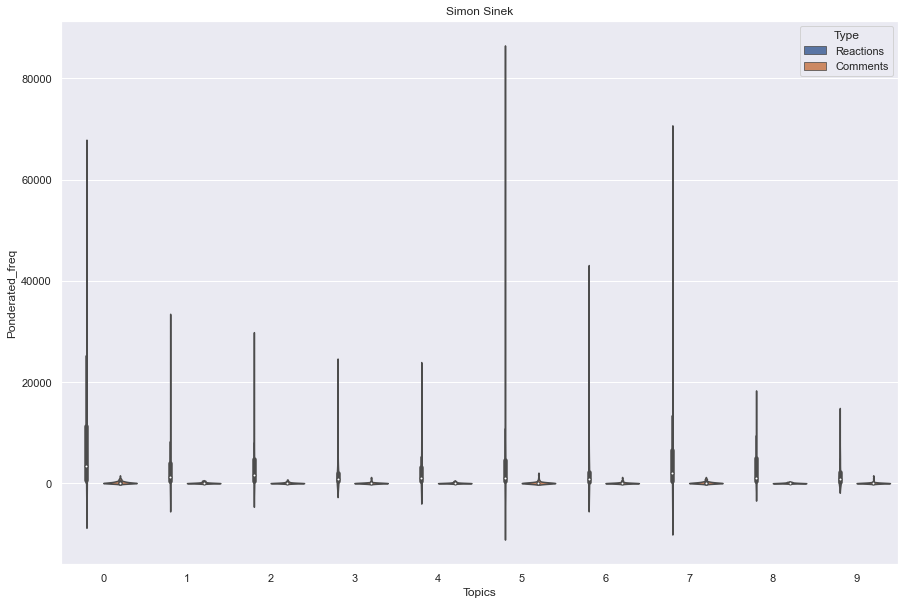

In [190]:
one_author_df = melted_df.loc[melted_df['Name']=="Simon Sinek"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")
ax.set(title='Simon Sinek')
sns.set(rc={'figure.figsize':(15,10)})

As we can see, the distribution of ponderated_frequency for each topics is too wide.  

Let's see with an other author :

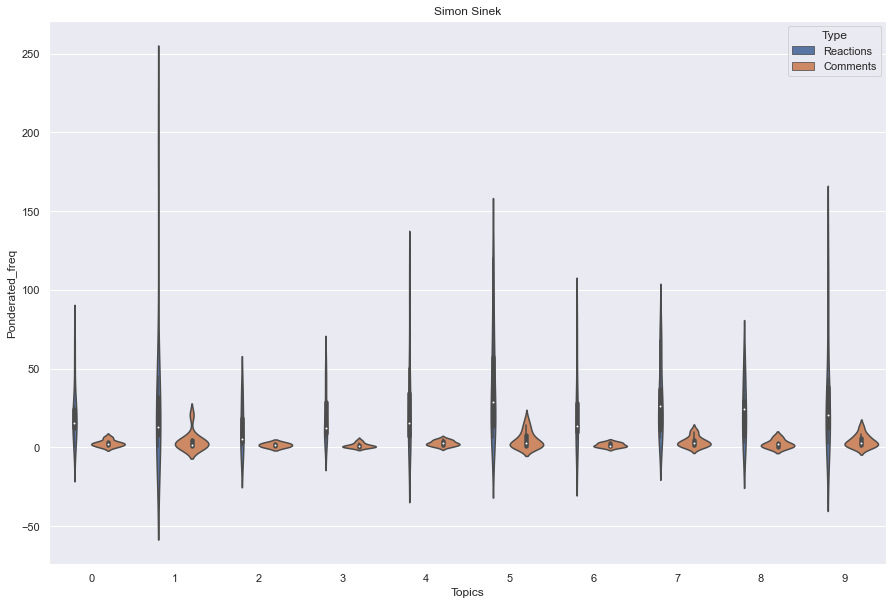

In [187]:
one_author_df = melted_df.loc[melted_df['Name']=="Sarah Kauss"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")
ax.set(title='Simon Sinek')
sns.set(rc={'figure.figsize':(15,10)})

There is something here but outliers conceal observations.
Let's try to remove them

In [227]:
# Filter with the 0.95 quantile and create the df
q = np.quantile(melted_df['Ponderated_freq'], q=0.95)
filtered_melted_df = melted_df.loc[melted_df['Ponderated_freq'] < q]

**Simon SINEK**

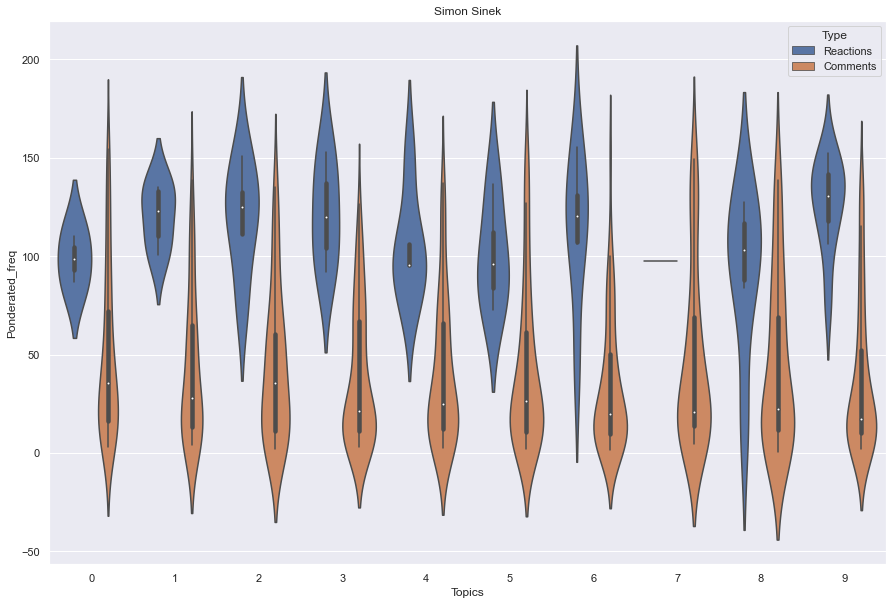

In [235]:
# Plot it
one_author_df = filtered_melted_df.loc[filtered_melted_df['Name']=="Simon Sinek"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")
ax.set(title='Simon Sinek')
sns.set(rc={'figure.figsize':(15,10)})

In [236]:
print("{} posts were considered here".format(one_author_df.shape[0]))

596 posts were considered here


**Sarah Kauss**

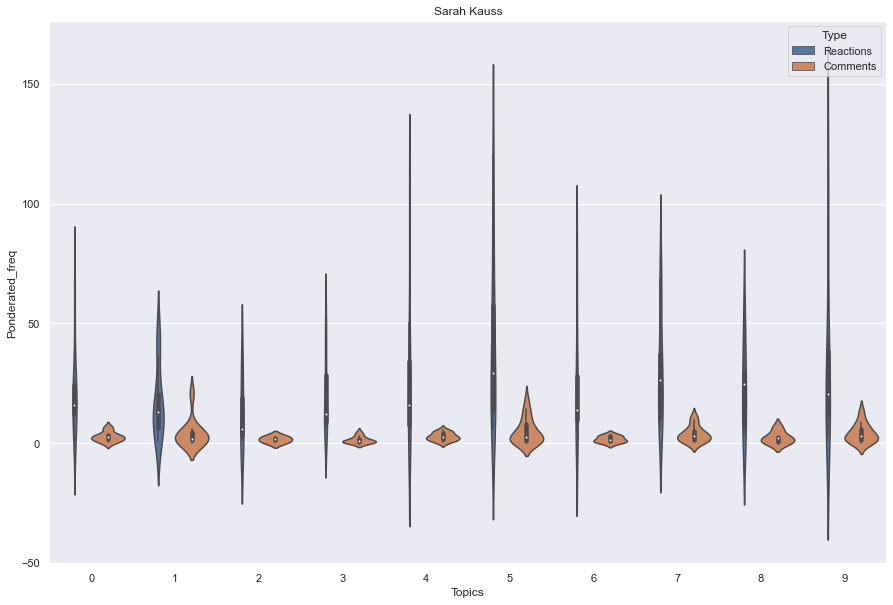

In [237]:
# Plot it
one_author_df = filtered_melted_df.loc[filtered_melted_df['Name']=="Sarah Kauss"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")
ax.set(title='Sarah Kauss')
sns.set(rc={'figure.figsize':(15,10)})

In [238]:
print("{} posts were considered here".format(one_author_df.shape[0]))

219 posts were considered here


**Michelle Chaffee**

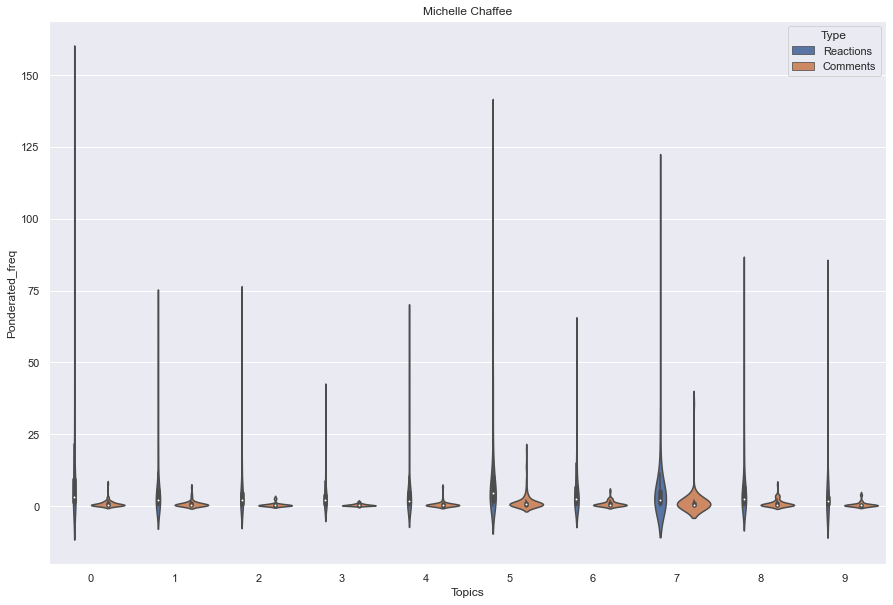

In [239]:
# Plot it
one_author_df = filtered_melted_df.loc[filtered_melted_df['Name']=="Michelle Chaffee"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")
ax.set(title='Michelle Chaffee')
sns.set(rc={'figure.figsize':(15,10)})

In [240]:
print("{} posts were considered here".format(one_author_df.shape[0]))

1974 posts were considered here


### Conclusions

From this study using ponderated reactions & comments depending of a post topics, we didn't succeed to highlight patterns considering different authors. 

It appears that the distribution of ponderated reactions and comments is too wide and doesn't allow us to draw a conclusion about this topic modeling section.

Topic modeling using LDA could be drastically improved, and more adequate topics could be found. 

Also, LinkedIn posts wasn't complete. Therefore an other web scraping could be done to increase the performance of this unsurpervized method. 

## General conclusions <a class="anchor" id="6"></a>

During this project, we studied the influence of adding a medium into a Linkedin post and we performed a topic modeling to draw the influence of topics on reactions and comments. 

The dataset was composed of American celebrities like Simon Sinek, Richard Branson, and others.

We showed that adding a media in the post would increase the attractivity ( (#reactions+#comments) / #followers) by 16%. We used a hypothesis test to verify this affirmation. 

Also, we defined 10 topics to represent all the posts we had in this dataset. However, our model didn't find relatively good topics for the human eye. We tried to highlight which topics have the most reaction and comments depending on topics proportion into a post. However, the results didn't show a clear pattern to make a decision. 

This could be resumed and improved in the near future. Don't hesitate if you have any suggestion or advice !

## Personnal note <a class="anchor" id="7"></a>

This project allowed me to discover NLP and topic modeling. I appreciated to do it and hope it will help in your future projects. 

Don't hesitate to leave a comment to give me advices or corrections. 

Thank you for the reading and I hope you enjoyed this project. 

## Acknowledgment <a class="anchor" id="8"></a>

I would like to thanks **Shreya Sajal** for the dataset you can find on this link on Kaggle : https://www.kaggle.com/shreyasajal/linkedin-influencers-data

I would like also aknowledge **Alice Zhao** and **Patrick Harisson** for their work and the fact they shared their knowledge about NLP on Youtube. This project wouldn't exist without them. 

**Alice Zhao**
Youtube : https://www.youtube.com/watch?t=2145&v=xvqsFTUsOmc&feature=emb_imp_woyt&ab_channel=PyOhio
Github : https://github.com/adashofdata

**Patrick Harisson**
Youtube : https://www.youtube.com/watch?v=6zm9NC9uRkk&t=3775s
Github : https://github.com/pwharrison